# Transformers: Background and Foundations


RNN (Recurrent Neural Network): An architecture designed for sequential data but prone to issues like vanishing gradients.
Attention Mechanism: A method that allows models to focus on relevant parts of input sequences.
Cosine Similarity: A metric for measuring the cosine of the angle between two vectors, indicating their similarity.
Embedding Layer: A neural network layer that maps categorical data to continuous, dense vector representations.


## Vanishing Gradient Problem

The vanishing gradient problem occurs when training deep neural networks using gradient-based optimization methods like backpropagation. As gradients are propagated backward through multiple layers, they can become extremely small (i.e., "vanish"). This results in very slow weight updates in early layers, making it difficult for the network to learn meaningful representations. This issue is particularly common with activation functions like sigmoid or tanh, which squash large input values into a small range (e.g., $[0,1]$ for sigmoid and $[−1,1]$ for tanh), leading to small derivatives.


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Let's take a look at an example network where the vanishing gradient problem exists.
We will try to train a neural network to solve the following problem:

> Given a list of 10 numbers, is the sum of those numbers greater than 5?

This is a nice problem because it should be very easy for a neural network to solve, and we can generate as much training and testing data as we require.

In [16]:
# Generate structured data: sum of inputs determines output
np.random.seed(2)
X_train = np.random.uniform(0, 1, size=(1000, 10))
y_train = (X_train.sum(axis=1) > 5).astype(int)

X_test = np.random.uniform(0, 1, size=(100, 10))
y_test = (X_test.sum(axis=1) > 5).astype(int)

In [17]:
# Define a deep neural network with sigmoid activations
model = keras.Sequential()
model.add(layers.Dense(64, activation="sigmoid", input_shape=(10,)))
for _ in range(10):  # Deep network with many layers
    model.add(layers.Dense(64, activation="sigmoid"))
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,369 (165.50 KB)

 Trainable params: 42,369 (165.50 KB)

 Non-trainable params: 0 (0.00 B)

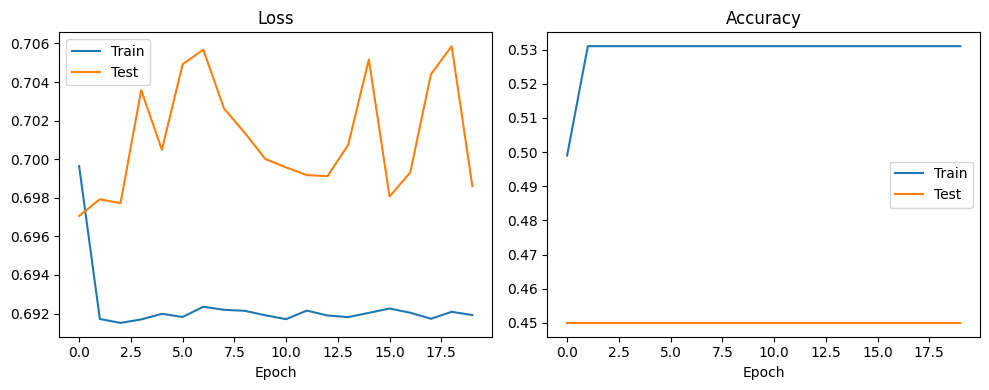

In [25]:
# Train the model and observe slow learning
# Use verbose = 0 here and only look at the plots at the end.
history = model.fit(X_train, y_train, epochs=20, verbose=0, validation_data=(X_test, y_test))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.tight_layout()

From these plots we can see that the vanishing gradient problem is causing our models's to fail in their training.

There are several approaches we could take to deal with this issue, and the right one would depend on what problem we are working on.

* Replace the sigmoid activation function with ReLU or other activation which does not have a vanishing gradient.
* Try batch normalization
* Try using an Adam optimizer
* Try a different weights initializer
* Use a shallower network

Each of these could potentially address our problem however...


## Vanishing Gradients and Recurrent Neural Networks

The vanishing gradient problem is especially severe in Recurrent Neural Networks (RNNs) due to the way they handle sequential data and backpropagate gradients through time steps.

### Gradients are Multiplied Many Times

* In a standard feedforward neural network, gradients are propagated backward through layers.
* In an RNN, gradients are propagated backward through time steps using Backpropagation Through Time
* At each time step, the gradient of the loss with respect to earlier layers (i.e., earlier time steps) is computed as the product of many small derivatives.

Since the weight updates involve multiplying gradients over many time steps, the values shrink exponentially if the derivatives are small (e.g., with sigmoid or tanh activations). This results in gradients that approach zero, making it difficult for earlier time steps to influence learning.

### Long-Term Dependencies Become Hard to Learn

* RNNs are designed to capture sequential dependencies, meaning that information from earlier time steps should influence later predictions.
* Due to vanishing gradients, information from early time steps is "forgotten" because the weights in those steps barely update.
* This makes it difficult for RNNs to learn long-range dependencies, where the output at time tt depends on an input from much earlier in the sequence.

### Advancements in RNNs

Over time, machine learning researchers devised methods to address this problem.
New techniques such as LSTM (long-short term memory), GRU (gated recurrent unit), gradient clipping, and ReLU activations helped.
However, ultimately a new type of network was invented which surpassed the RNN.

# Enter: Transformers

In 2017, a [new paper](https://arxiv.org/pdf/1706.03762) was published by researchers at Google titled "Attentoin is all you need."
In this paper, the authors introduced the transformer.
This type of neural network eventually went on to dominate the AI industry and is behind most advancements in the last few years.
For example, you may have heard of GPT.
The "T" stands for "transformer."

Our goal for the next few classes is to introduce you all the the ideas that power transformers.
This is a very big topic and could probably take up _several semsters_ of study, so we will only be able to scratch the surface!

# Embeddings

Up until now, we have focused exclusively on _continuous inputs_ to models.
In the real world however, we frequently encounter _categorical data_.
Examples of cateogorical data could include:

* Color of a flower
* ZIP code
* Highest level of education achieved
* Words

And many, _many_ other examples.

## Numerical Encodings of Categorical Inputs

As mathematical functions, neural networks require that inputs be numerical.

> $f(x) = x^2$
> 
> $f(\text{cat}) = ???$

For this reason, we need to come up with a way to transform categorical inputs into numerical inputs.

Traditionally, this is done via _one-hot-encoding_ (also called dummy variables).

In [31]:
# We can use the pandas function pd.get_dummies to compute the one-hot encoded categorical variables

data = pd.Series(['cat', 'cat', 'dog', 'monkey', 'dog'], name='animal')

print(data)

pd.get_dummies(data).astype(float)

0       cat
1       cat
2       dog
3    monkey
4       dog
Name: animal, dtype: object


,cat,dog,monkey
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


The resulting features matrix contains only 1s and 0s and is suitable to be used in a neural network (or other ML model).

One hot encoding fails to be useful, though, once you get into categorical variables with lots of possible values.
Consider for example a language model which takes as it's input an English sentence and outputs 1 if the sentence has good grammar and 0 otherwise.
The Oxford disctionary contains over 170,000 unique words (not counting misspellings)!
Using one-hot encoding in this situation would be very bad for memory and numerical stability reasons.
A better solution was required.

## Embeddings

The idea behind embeddings is to encode each category as an _n-dimensional vector_ instead of as a 1 or a 0

$$\begin{array}{ccc}
\text{cat} & \rightarrow & [1.0, \,\,\, -.04] \\
\text{dog} & \rightarrow & [0.2, \,\,\, 2.35] \\
\text{monkey} & \rightarrow & [-2.3, \,\,\, -0.77]
\end{array}$$

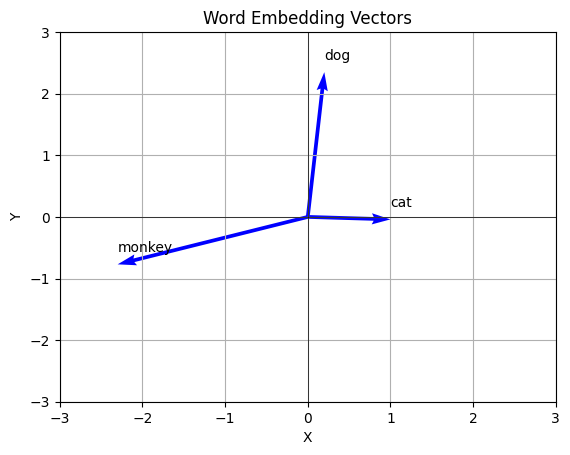

In [43]:
# Plotting our word-embedding

vectors = {
    "cat": np.array([1.0, -0.04]),
    "dog": np.array([0.2, 2.35]),
    "monkey": np.array([-2.3, -0.77])
}

fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Word Embedding Vectors")
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

for word, vec in vectors.items():
    ax.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color='b')
    ax.text(vec[0], vec[1]+0.2, word, fontsize=10, color='black')

plt.grid()

### Why Are Embeddings Useful?

* Dimensionality Reduction: Instead of using sparse one-hot encoding or high-dimensional categorical representations, embeddings condense information into a lower-dimensional space while preserving relationships.
* Semantic Similarity: Similar entities (e.g., words in NLP or products in a recommendation system) tend to have similar embeddings, allowing models to leverage these relationships.
* Efficient Learning: Embeddings allow neural networks to learn more generalized patterns and relationships rather than treating categorical data as independent and unrelated entities.
* Transferability: Pretrained embeddings, such as Word2Vec, GloVe, or BERT embeddings in NLP, can be transferred across tasks, enabling better generalization with fewer data points.

### Embedding Layers In Keras

Let's try out an example embedding layer using Keras.

In [49]:
# Define vocabulary size and embedding dimensions
vocab_size = 10  # Assume we have 10 unique words
embedding_dim = 4  # Each word will be represented by a 4D vector

model = Sequential([
    layers.Input((3, )),
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=3),
    layers.Flatten(),  # Flatten the embedding output for use in a dense layer
    layers.Dense(1, activation='sigmoid')  # Dummy output layer
])

# Print model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 3, 4)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (212.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Sample input: a batch of word indices
sample_input = np.array([[1, 2, 3], [4, 5, 6]])  # Example word indices

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.49988472],
       [0.51777077]], dtype=float32)>

# Cosine Similarity

> _Cosine similarity_ is a metric used to measure how similar two vectors are regardless of their magnitude. It calculates the cosine of the angle between two vectors in a multi-dimensional space. A cosine similarity of 1 means the vectors are identical, while a cosine similarity of 0 means they are orthogonal (completely different).

## Calculation

To calculate the cosine similarity of two vectors, we rely on this fact about the vector dot product.
For two vectors $\vec{v}$ and $\vec{w}$,
$$\vec{v} \cdot \vec{w} = ||\vec{v}|| ||\vec{w}|| \cos(\theta)$$
where $||\vec{v}||$ means the magnitude of $\vec{v}$, and $\theta$ is the angle between $\vec{v}$ and $\vec{w}$.
Rearranging, we get
$$\cos(\theta) = \frac{\vec{v} \cdot \vec{w}}{||\vec{v}|| ||\vec{w}||}$$
the formula for cosine similarity.

## Properties

* Range of $[-1, 1]$ (notice square brackets, so -1, and 1 are possible values)
* If the cosine similarity of two vectors equals 1, those vectors point in exactly the same direction
* If the cosine similarity of two vectors equals 0, those vectors are orthogonal

## Example Calculating Cosine Similarity

Let's do some examples of calculating cosine similarity

$$\vec{v} = [1, -1, 3, 5]$$
$$\vec{w} = [-4, 2, 1, 2]$$

First, calculate the vectors magnitudes:

$$||\vec{v}|| = \sqrt{(1)^2 +  (-1)^2 + (3)^2 + (5)^2} = \sqrt{1 + 1 + 9 + 25} = \sqrt{36} = 6$$
$$||\vec{w}|| = \sqrt{(-4)^2 + (2)^2 + (1)^2 + (2)^2}= \sqrt{16 + 4 + 1 + 4} = \sqrt{25} = 5$$

Next, let's calculate the dot product of $\vec{v}$ and $\vec{w}$:

$$\vec{v} \cdot \vec{w} = (1)(-4) + (-1)(2) + (3)(1) + (5)(2) = -4 - 2 + 3 + 10 = 7.$$

Putting it all together, we get:

$$\cos(\theta) = \frac{\vec{v} \cdot \vec{w}}{||\vec{v}|| ||\vec{w}||} = \frac{7}{6 \cdot 5} \approx .2333$$

Note that we _could_ use the $\cos^{-1}$ function get $\theta$ (which would give us 1.34 radians) but in our use case _we do not care_ about $\theta$, we only need the cosine similarity.

In [65]:
# Check our work using numpy

v = np.array([1, -1, 3, 5])
w = np.array([-4, 2, 1, 2])

cosine_sim = (v @ w) / (np.linalg.norm(v) * np.linalg.norm(w))

print(f"Cosine similarity of v and w = {cosine_sim:0.4f}")

Cosine similarity of v and w = 0.2333


# What is Attention?

The attention mechanize consists of three matrices:

* $Q$, the query matrix
* $K$, the key matrix
* $V$, the value matrix

These matrices are combined into the _attention formula_:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where $d_k$ is the dimension of the key vectors.

---

Let's break this formula down piece by piece before jumping into examples with code.

## Query and Key

The query matrix contains a collection of embedding vectors from input data:

> **Input** = "The root of suffering is attachment."
> 
> (-Buddha)

We take each token (word) in this input and look up its embedding vector:

$$Q = \left[\begin{matrix}
\uparrow & \uparrow & \cdots & \uparrow \\
\vec{v}_{\text{the}} & \vec{v}_{\text{root}} & \cdots & \vec{v}_{\text{suffering}} \\
\downarrow & \downarrow & \cdots & \downarrow 
\end{matrix}\right]$$

The key matrix is multiplied by the query matrix.

$$QK^T$$

By convention, we multiply by the transpose of $K$ so that $K$ and $Q$ have the same number of columns.

> Let's think again about what the matrix product is actually doing here.
> For two matrices $A$ and $B$, the matrix product $C = AB$ has the property that 
> $$c^{(i)}_j = \vec{a}_j \cdot \vec{b}^{(i)}.$$
> In other words, the entries of the resulting product matrix are exactly the dot product of a row from $A$ and a column from $B$.

From our discussion of the cosine similarity, we know that the dot product makes up the numerator of the cosine similarity calculation.

> _But what about dividing by the product of the magnitudes?_
>
> Originally, this is what people had done in attention models, however experimentation found that removing this normalization step improved model convergence. Instead, we divide by $\sqrt{d_k}$ which has shown to overall work better.

At this point, then, we have a matrix $d_k^{1/2} \cdot (QK^T)$ which contains entries which measure something like the similarity of each vector in the query with each vector in the key.

## Softmax

The next step is to apply the softmax function. Recall
$$\text{softmax}\left(\vec{x}\right) = \frac{1}{\sum_{j=0}^N e^{x_j}} \cdot \left[\begin{array}{c}
e^{x_0} \\
\vdots \\
e^{x_N}
\end{array} \right]$$
is a function which transforms a vector of real numbers into a vector which we can interpret as probabilites.
The largest entry in the input vector will get the largest probability in the output vector.
(Note: "large" here means positive. A big negative number would be considered "small")

Applying softmax to a matrix just means applying softmax to each column of that matrix.
The result of the expression
$$\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)$$
can therefore be interpreted as a matrix whose columns contain the probabilty information about similarity of the columns of $Q$ and the columns of $K$.
This result is called the _attention scores._

### The Value Matrix

The last component of the attention formula is to multiply by the value matrix $V$.
The value matrix contains vectors which are the actual information which the attention scores will retrieve.

### A Brief Pause

It is worth taking a moment here to acknoledge that what we have just gone over here is _complicated_ and will be a little much to grasp the first time.
If you feel a little overwhelmed, know that that is normal and totally okay!
Take a breather and let it simmer in your mind.
Come back after a bit and re-read this section when you feel ready!

In [78]:
# Define example Q, K, V tensors

query = tf.constant([
    [1.0, 0.0, 0.0]
], dtype=tf.float32)  # Shape (1, 3)

key = tf.constant([
    [1.0, 0.5, 0.0], 
    [0.0, 1.0, 0.5], 
    [0.5, 0.0, 1.0]],
dtype=tf.float32)  # Shape (3, 3)

value = tf.constant([
    [1.0, 2.0], 
    [3.0, 4.0], 
    [5.0, 6.0]
], dtype=tf.float32)  # Shape (3, 2)

# Compute dot product of Q and K^T
attention_scores = tf.matmul(query, key, transpose_b=True)


print("Attention Scores:\n", attention_scores.numpy())

Attention Scores:
 [[1.  0.  0.5]]


In [70]:
d_k = tf.cast(tf.shape(key)[-1], tf.float32)  # Dimension of key vectors

# Apply softmax to get attention weights
attention_weights = tf.nn.softmax(attention_scores / tf.sqrt(d_k), axis=-1)

print("Attention Weights:\n", attention_weights.numpy())

Attention Weights:
 [[0.4327806  0.24295606 0.32426327]]


In [71]:
# Compute weighted sum
attention_output = tf.matmul(attention_weights, value)
print("Attention Output:\n", attention_output.numpy())

Attention Output:
 [[2.7829652 3.7829652]]


# Final Notes

This week we laid the groudwork for building a transformer based model.
In the following weeks, we will look at how to take these components and build a deep neural network!

# Homework

1. What do you think is the main advantage that transformers and attention have over recurrent neural networks?
3. Consider this Python dictionary as an embedding:

```python
embedding = {
    "am": np.array([-0.3, -0.1, -0.3]),
    "enemy": np.array([-0.3,  0.1, -1.0]),
    "fast": np.array([ 1.5,  1.3, -1.0]),
    "friend": np.array([-0.3,  0.4, -1.0]),
    "happy": np.array([-0.6,  0.1, -0.5]),
    "hate": np.array([-0.7,  0.6,  0.1]),
    "I": np.array([ 1.2,  1.5, -0.1]),
    "love": np.array([-0.3, -1.0,  0.7]),
    "sad": np.array([0.4, 1.4, 2.3]),
    "slow": np.array([0.8, 1.8, 0.5])
}
```

Write a python function which will construct a query matrix from an input string which words from the dictionary.

```python
def get_query_string(s: str):
    # Define the function here

    return query_matrix
```

Hint: You may want to use the [hstack](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) function in numpy.

3. Use your function from 2. to create a query matrix for the sentence "I am happy"

4. Consider these key and value matries:
$$K = \left[\begin{matrix}
1 & 1 & 0 \\
0 & 1 & 1 \\
1 & 0 & -1 \\
-1 & 0 & 0
\end{matrix}\right] \,\,\,\,\,\,\,\,\,\,
V = \left[\begin{matrix}
1 & 2 \\
3 & 4 \\
5 & 6
\end{matrix}\right]$$

Compute the attention function of $K$, $V$, and $Q$ from the problem 3.
You can do this either using numpy or tensorflow to do the matrix opperations.